In [1]:
import xarray as xr
import numpy as np
import os
from metpy import calc as mpcalc

In [2]:
if os.path.basename(os.path.expanduser("~")) == 'bfildier':
    inputdir = '/Users/bfildier/Data/EUREC4A/merged/sondes'
    sonde_path = os.path.join(inputdir,'all_sondes.nc')
    sondes = xr.open_dataset(sonde_path)
else:    
    inputdir = "/run/media/ludo/DATA/google-drive/Thèse/EUREC4a/github/Input/"
    sonde_path = os.path.join(inputdir, "all_sondes.nc")
    sondes = xr.open_dataset(sonde_path)


In [3]:
# T_0 = 273.15           # K
# R_d = 287.04           # J/kg/K
# R_v = 461.4            # J/kg/K
# g_to_kg = 0.001

# ## Saturation vapor pressure from Buck (1981)
# def saturationVaporPressure(temp):

#     """Argument: Temperature (K) as a numpy.ndarray or dask.array
#     Returns: saturation vapor pressure (Pa) in the same format."""

#     whereAreNans = np.isnan(temp)
#     temp_wo_Nans = temp.copy()
#     temp_wo_Nans[whereAreNans] = 0.
#     # Initialize
#     e_sat = np.zeros(temp.shape)
#     e_sat[whereAreNans] = np.nan
#     #!!! T > 0C
#     overliquid = (temp_wo_Nans > T_0)
#     ## Buck
#     e_sat_overliquid = 611.21*np.exp(np.multiply(18.678-(temp-T_0)/234.5,
#                                                   np.divide((temp-T_0),257.14+(temp-T_0))))
#     e_sat[overliquid] = e_sat_overliquid[overliquid]
#     #!!! T < 0C 
#     overice = (temp_wo_Nans < T_0)
#     ## Buck
#     e_sat_overice = 611.15*np.exp(np.multiply(23.036-(temp-T_0)/333.7,
#                                                np.divide((temp-T_0),279.82+(temp-T_0))))
#     e_sat[overice] = e_sat_overice[overice]

#     return e_sat       # in Pa

# ## Compute the saturation specific humidity based on the expressions by Buck
# def saturationSpecificHumidity(temp,pres):

#     """Convert from estimate of saturation vapor pressure to saturation specific
#     humidity using the approximate equation qvsat ~ epsilon"""

#     e_sat = saturationVaporPressure(temp)
#     qvstar = (e_sat/R_v)/(pres/R_d)

#     return qvstar

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


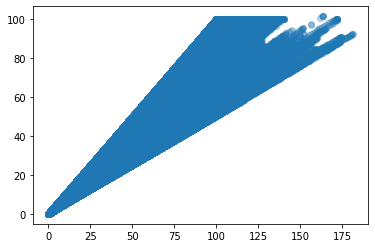

In [4]:
# qvstar = saturationSpecificHumidity(sondes.temperature.values+273.15,sondes.pressure.values*100)
# rh_estimate = sondes.specific_humidity.values/qvstar*100

# import matplotlib.pyplot as plt
# plt.scatter(rh_estimate,sondes.relative_humidity,alpha=0.3)

In [3]:
sondes

<xarray.Dataset>
Dimensions:            (height: 3000, launch_time: 2522)
Coordinates:
  * height             (height) float64 0.0 10.0 20.0 ... 2.998e+04 2.999e+04
  * launch_time        (launch_time) datetime64[ns] 2020-01-19T16:55:14 ... 2020-02-16T04:14:33
    latitude           (launch_time, height) float64 ...
    longitude          (launch_time, height) float64 ...
Data variables:
    pressure           (launch_time, height) float64 ...
    temperature        (launch_time, height) float64 ...
    relative_humidity  (launch_time, height) float64 ...
    wind_speed         (launch_time, height) float64 ...
    wind_direction     (launch_time, height) float64 ...
    u_wind             (launch_time, height) float64 ...
    v_wind             (launch_time, height) float64 ...
    specific_humidity  (launch_time, height) float64 ...
    Platform           (launch_time) object ...
    ascent_flag        (launch_time) float64 ...
Attributes:
    Title:                        Gridded, sounding data from JOANNE Level-2
    Campaign:                     EUREC4A-ATOMIC (Jan-Feb, 2020)
    Instrument:                   Vaisala RD41 (AVAPS receiver aboard aircraft)
    Data Processing for Level-2:  AvapsEditorVersion "BatchAspen V3.4.3"
    Author:                       Geet George (MPI-M, Hamburg); geet.george@m...
    version:                      v0.1.0-3-g475a114
    Conventions:                  CF-1.7
    featureType:                  trajectory
    Creation Time:                2020-04-28 10:45:10.585477 UTC

In [9]:
def replace_with_mean(sondes,varid):
    # take mean
    var_mean = sondes.variables[varid].mean(axis=0).values[np.newaxis,:]
    # duplicate
    var_mean_ntimes = np.repeat(var_mean,
              sondes.dims['launch_time'],0)
    # assign in xarray
    return sondes.update({varid:(('launch_time','height'),var_mean_ntimes)})
    

In [13]:
var2avg = 'Q'
varids = {'T':'temperature','Q':'specific_humidity','RH':'relative_humidity'}
varid = varids[var2avg]

# Need to reload original dataset each time
# so far it is affected by the averaging
sondes = xr.open_dataset(sonde_path)

# Average chosen variable
proxysondes = replace_with_mean(sondes,varid)
if var2avg in ['T','Q']:
    proxysondes.drop_vars('relative_humidity')

#TODO # if var2avg is temperature or Q, recalculate RH
#TODO # (not necessary, to make it consistent)

#TODO # if var2avg is RH, recalculate Q
#TODO # (required for radiative calculation)

In [14]:
proxysondes

<xarray.Dataset>
Dimensions:            (height: 3000, launch_time: 2522)
Coordinates:
  * height             (height) float64 0.0 10.0 20.0 ... 2.998e+04 2.999e+04
  * launch_time        (launch_time) datetime64[ns] 2020-01-19T16:55:14 ... 2020-02-16T04:14:33
    latitude           (launch_time, height) float64 ...
    longitude          (launch_time, height) float64 ...
Data variables:
    pressure           (launch_time, height) float64 ...
    temperature        (launch_time, height) float64 ...
    relative_humidity  (launch_time, height) float64 ...
    wind_speed         (launch_time, height) float64 ...
    wind_direction     (launch_time, height) float64 ...
    u_wind             (launch_time, height) float64 ...
    v_wind             (launch_time, height) float64 ...
    specific_humidity  (launch_time, height) float64 0.01505 ... 5.002e-05
    Platform           (launch_time) object ...
    ascent_flag        (launch_time) float64 ...
Attributes:
    Title:                        Gridded, sounding data from JOANNE Level-2
    Campaign:                     EUREC4A-ATOMIC (Jan-Feb, 2020)
    Instrument:                   Vaisala RD41 (AVAPS receiver aboard aircraft)
    Data Processing for Level-2:  AvapsEditorVersion "BatchAspen V3.4.3"
    Author:                       Geet George (MPI-M, Hamburg); geet.george@m...
    version:                      v0.1.0-3-g475a114
    Conventions:                  CF-1.7
    featureType:                  trajectory
    Creation Time:                2020-04-28 10:45:10.585477 UTC

In [15]:
# save file
new_filename = 'proxy_sondes_fixed%s.nc'%var2avg
proxysondes.to_netcdf(os.path.join(inputdir,new_filename))